In [1]:
!git clone https://github.com/PiotrJZielinski/ml-throwdown-datasets

fatal: destination path 'ml-throwdown-datasets' already exists and is not an empty directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# losowe dane dla dwóch klas, przy przesunięciu środka rozkładu
train_data = np.vstack((np.random.normal(size=(100, 2)),
                        np.random.normal(size=(100, 2), loc=2)))
train_labels = np.hstack((np.zeros(100), np.ones(100)))


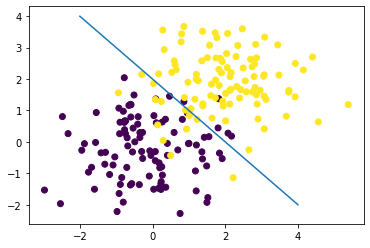

In [3]:
fig, ax = plt.subplots()
ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels)
ax.plot(range(-2, 5), range(4, -3, -1))
plt.show()

In [4]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(train_data, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [5]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))


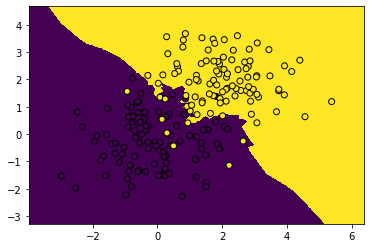

In [6]:
xs, ys = get_grid(train_data)

predicted = knn.predict(
    np.column_stack((xs.flatten(),
                     ys.flatten()))).reshape(xs.shape)

fig, ax = plt.subplots()
ax.pcolormesh(xs, ys, predicted)
ax.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, edgecolors='k')
plt.show()

Wczytamy teraz dane rzeczywiste i spróbujemy ocenić poprawność działania modelu

In [7]:
import pandas as pd

def load_dataset(filename, class_column, index_col=None):
    dataset = pd.read_csv(f'ml-throwdown-datasets/{filename}.csv', index_col=index_col)
    dataset['class'] = dataset[class_column].astype('category').cat.codes
    classes = dataset.pop(class_column).unique()
    return dataset, classes

def prepare_dataset(dataset_name):
    params = {'iris': {'class_column': 'species', 'index_col': None},
              'wine': {'class_column': 'Class', 'index_col': None},
              'glass': {'class_column': 'Type', 'index_col': 'ID'},
              'diabetes': {'class_column': 'Class', 'index_col': None}}
    dataset, classes = load_dataset(dataset_name,
                                    **params[dataset_name])
    y = dataset.pop('class')
    X = dataset
    return X, y, classes

In [8]:
X, y, classes = prepare_dataset('iris')

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# average:
#   None - wyniki dla każdej klasy osobno
#   'binary' - dla wybranej w `pos_label` etykiety
#   'micro' - dla całkowitej liczby TP, FN, FP
#   'macro' - nieważona średnia dla każdej klasy
#   'weighted' - ważona średnia dla każdej klasy

def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

In [16]:
print_results(calculate_metrics(y_train, y_train_pred), classifier_id='knn-4-train')
print_results(calculate_metrics(y_test, y_pred), classifier_id='knn-4')

Results for knn-4-train
----
  Accuracy:  0.9732142857142857
  Precision: 0.9736467236467236
  Recall:    0.9732100521574206
  F1 score:  0.9733143568760007
  Mislabeled 3 out of 112


Results for knn-4
----
  Accuracy:  0.9210526315789473
  Precision: 0.9220779220779222
  Recall:    0.9188034188034188
  F1 score:  0.9194847020933977
  Mislabeled 3 out of 38




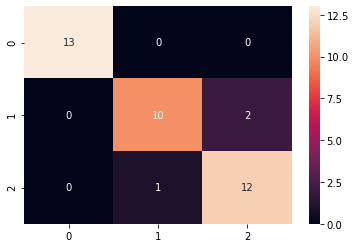

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)


Teraz zróbmy to samo dla zbioru win!

In [19]:
X, y, classes = prepare_dataset('wine')

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [21]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)

In [22]:
print_results(calculate_metrics(y_train, y_train_pred), classifier_id='knn-wine-4-train')
print_results(calculate_metrics(y_test, y_pred), classifier_id='knn-wine-4')

Results for knn-wine-4-train
----
  Accuracy:  0.8195488721804511
  Precision: 0.8252929386370645
  Recall:    0.8303475001588209
  F1 score:  0.817932662549841
  Mislabeled 24 out of 133


Results for knn-wine-4
----
  Accuracy:  0.7111111111111111
  Precision: 0.7019632414369257
  Recall:    0.7092592592592593
  F1 score:  0.6981209150326797
  Mislabeled 13 out of 45




Jest dużo gorzej! dlaczego?

In [24]:
X.mean()

Alcohol                          13.000618
Malic acid                        2.336348
Ash                               2.366517
Alcalinity of ash                19.494944
Magnesium                        99.741573
Total phenols                     2.295112
Flavanoids                        2.029270
Nonflavanoid phenols              0.361854
Proanthocyanins                   1.590899
Color intensity                   5.058090
Hue                               0.957449
OD280/OD315 of diluted wines      2.611685
Proline                         746.893258
dtype: float64

Wszystko przez proline. Spróbujmy powtórzyć klasyfikację bez Proline

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], y, stratify=y)

In [27]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)

In [28]:
print_results(calculate_metrics(y_train, y_train_pred), classifier_id='knn-wine-4-train')
print_results(calculate_metrics(y_test, y_pred), classifier_id='knn-wine-4')

Results for knn-wine-4-train
----
  Accuracy:  0.8872180451127819
  Precision: 0.903325986776197
  Recall:    0.8878406708595389
  F1 score:  0.8881370923161969
  Mislabeled 15 out of 133


Results for knn-wine-4
----
  Accuracy:  0.7555555555555555
  Precision: 0.7751082251082252
  Recall:    0.7611111111111111
  F1 score:  0.7584886128364389
  Mislabeled 11 out of 45




Ale wyrzucanie to nie jest chyba najlepsze rozwiązanie. Można zamiast tego zastosować któryś z rodzajów normalizacji.

In [42]:
from sklearn.preprocessing import Normalizer, StandardScaler

normalizer = Normalizer()
standardizer = StandardScaler()

preprocesser = normalizer # standardizer jest lepszy!

In [43]:
if preprocesser is not None:
    preprocesser.fit(X)
    X_preprocessed = preprocesser.transform(X.values)
    X[:] = X_preprocessed
X.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,-0.352665,-0.327181,-0.378124,-0.436497,-0.236767,-0.208676,-0.025856,-0.377634,-0.080780,-0.209512,-0.266472,-0.066244,0.257635
1,-0.313077,-0.249586,-0.353501,-0.430777,-0.323364,-0.186098,-0.060994,-0.315064,-0.291745,-0.255843,-0.201806,-0.120001,0.285096
2,-0.389682,-0.221873,-0.319007,-0.338891,-0.395520,-0.226761,-0.044405,-0.322556,-0.008655,-0.214457,-0.266679,-0.215550,0.323712
3,-0.363598,-0.248680,-0.360702,-0.349933,-0.361459,-0.142840,-0.089458,-0.332191,-0.192430,-0.140825,-0.316241,-0.218693,0.281586
4,-0.399314,-0.125777,0.199052,-0.268509,0.170866,0.274555,0.475903,-0.235009,0.051065,-0.539396,-0.147978,-0.040638,0.098064


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], y, stratify=y)

In [45]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_train_pred = knn.predict(X_train)

In [46]:
print_results(calculate_metrics(y_train, y_train_pred), classifier_id='knn-wine-4-train')
print_results(calculate_metrics(y_test, y_pred), classifier_id='knn-wine-4')

Results for knn-wine-4-train
----
  Accuracy:  0.9624060150375939
  Precision: 0.9632132132132133
  Recall:    0.9685534591194968
  F1 score:  0.964439386166133
  Mislabeled 5 out of 133


Results for knn-wine-4
----
  Accuracy:  0.8666666666666667
  Precision: 0.8910256410256411
  Recall:    0.8888888888888888
  F1 score:  0.8723809523809525
  Mislabeled 6 out of 45




### Kroswalidacja

Results for KNN + CV
----
  Accuracy:  0.9382022471910112
  Precision: 0.9425490196078431
  Recall:    0.948356807511737
  F1 score:  0.9415854097845185
  Mislabeled 11 out of 178




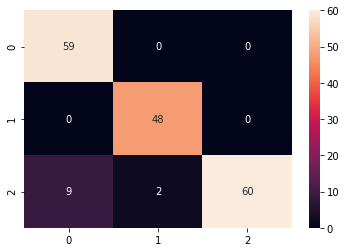

In [48]:
from sklearn.model_selection import KFold, StratifiedKFold

cross_val = KFold(n_splits=5, shuffle=True)

predicted = []
target = []

for train_index, test_index in cross_val.split(X):
    knn = KNeighborsClassifier()
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    knn.fit(X_train_cv, y_train_cv)
    predicted = np.concatenate((predicted, knn.predict(X_test_cv)))
    target = np.concatenate((target, y_test_cv))

print_results(calculate_metrics(target, predicted), 'KNN + CV')
cm_knn = confusion_matrix(target, predicted)

sns.heatmap(cm_knn, annot=True)

In [49]:
def cross_validate(classifier, kfold, X, y, params=None, talk=True):
    if params is None:
        params = {}
    if classifier.__class__.__name__ == 'ABCMeta':
        clf = classifier(**params)
    else:
        clf = classifier
    predicted = []
    target = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X=X_train, y=y_train)
        predicted = np.concatenate((predicted, clf.predict(X_test)))
        target = np.concatenate((target, y_test))
    
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    if talk:
        print_results(metrics, clf.__class__.__name__)
        sns.heatmap(cm, annot=True)
        plt.show()
    else:
        return metrics, cm

Results for KNeighborsClassifier
----
  Accuracy:  0.9213483146067416
  Precision: 0.9201972455648925
  Recall:    0.928818201108724
  F1 score:  0.9226349160823132
  Mislabeled 14 out of 178




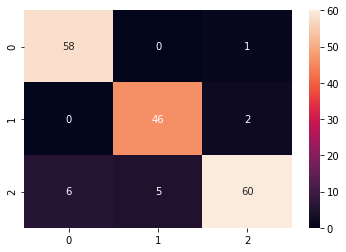

In [50]:
cross_validate(KNeighborsClassifier, StratifiedKFold(10), X, y)

Testy parametrów

In [51]:
def plot_results(result_df, title, plot_type='bar'):
    ind = np.arange(len(result_df))
    fig, ax = plt.subplots(figsize=(20, 10))
    width = 1 / len(result_df.columns)
    if plot_type == 'bar':
        plot = lambda index, data, label: ax.bar(index, data, width=width, label=label)
    elif plot_type == 'plot':
        plot = lambda index, data, label: ax.plot(index, data, label=label)
    plot(ind, result_df['accuracy'], 'Accuracy')
    plot(ind+width, result_df['precision'], 'Precision')
    plot(ind+2*width, result_df['recall'], 'Recall')
    plot(ind+3*width, result_df['fscore'], 'fscore')
    
    ax.set_title(title)
    ax.set_ylabel('Scores')
    ax.set_xlabel(result_df.index.name)
    ax.set_xticks(ind + 3 * width / 2)
    ax.set_xticklabels(result_df.index)
    ax.autoscale()
    ax.legend()
    return ax

def test_params(X, y, classifier, classifier_param, classifier_const_params=None,
                kfold=None,
                normalizer=None):
    X = X.copy()
    if classifier_const_params is None:
        classifier_const_params = {}
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    param = list(classifier_param.keys())[0]
    data = {param: [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, value in enumerate(list(classifier_param.values())[0]):
        kwargs = {param: value}
        clf = classifier(**kwargs, **classifier_const_params)
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(clf,
                                     kfold,
                                     X, y,
                                     talk=False)
        data[param].append(value)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index(param)
    return plot_results(df, f'{clf.__class__.__name__} - {param}', plot_type='plot'), df

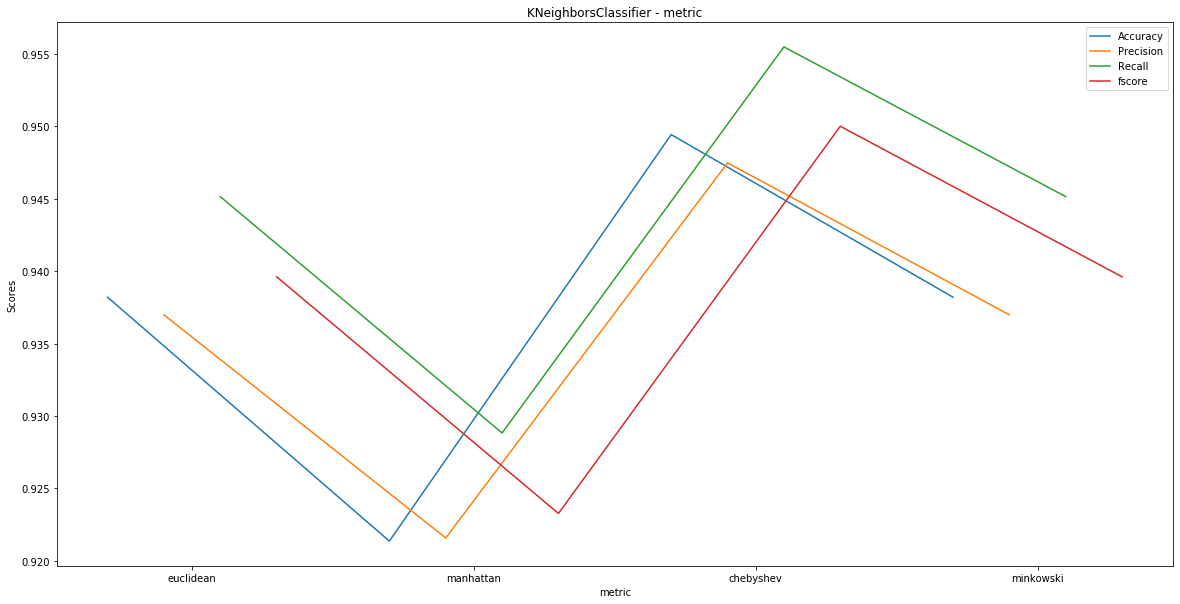

In [57]:
ax, results = test_params(X, y, KNeighborsClassifier, {'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']},
                         {'n_neighbors': 3})

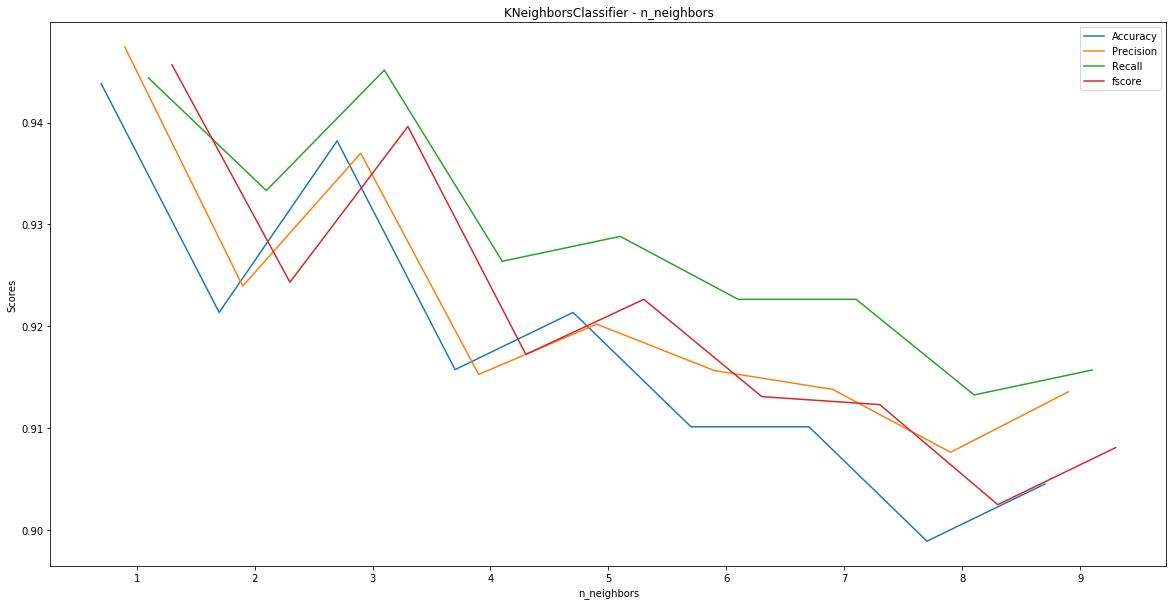

In [58]:
ax, results = test_params(X, y, KNeighborsClassifier, {'n_neighbors': range(1,10)},)

In [59]:
def test_classifiers(X, y, classifiers,
                     kfold=None,
                     normalizer=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    data = {'classifier': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, classifier in enumerate(classifiers):
        name =  f"{classifier.__class__.__name__}-{index}"
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X, y,
                                     talk=False)
        data['classifier'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('classifier')
    return plot_results(df, 'Classifiers comparison'), df

(<matplotlib.axes._subplots.AxesSubplot at 0x1a285d44a8>,
                         accuracy  precision    recall    fscore  \
 classifier                                                        
 KNeighborsClassifier-0  0.938202   0.936985  0.945152  0.939611   
 KNeighborsClassifier-1  0.893258   0.905964  0.906299  0.897605   
 
                                                            cm  
 classifier                                                     
 KNeighborsClassifier-0   [[58, 0, 1], [0, 47, 1], [5, 4, 62]]  
 KNeighborsClassifier-1  [[59, 0, 0], [1, 46, 1], [14, 3, 54]]  )

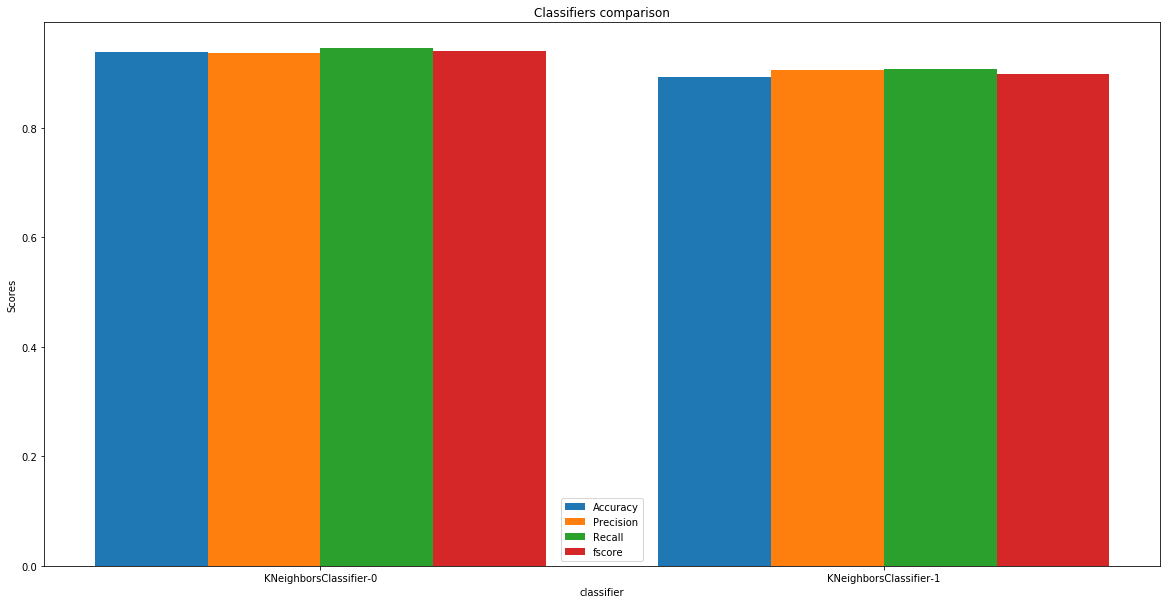

In [61]:
test_classifiers(X, y, [KNeighborsClassifier(n_neighbors=3), KNeighborsClassifier(n_neighbors=10)])

In [62]:
def test_folds(X, y, classifier, folds, kfold=None,
               normalizer=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    data = {'folds': folds,
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for n in folds:
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold(n),
                                     X, y,
                                     talk=False)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('folds')
    return plot_results(df, 'Number of folds', plot_type='plot'), df

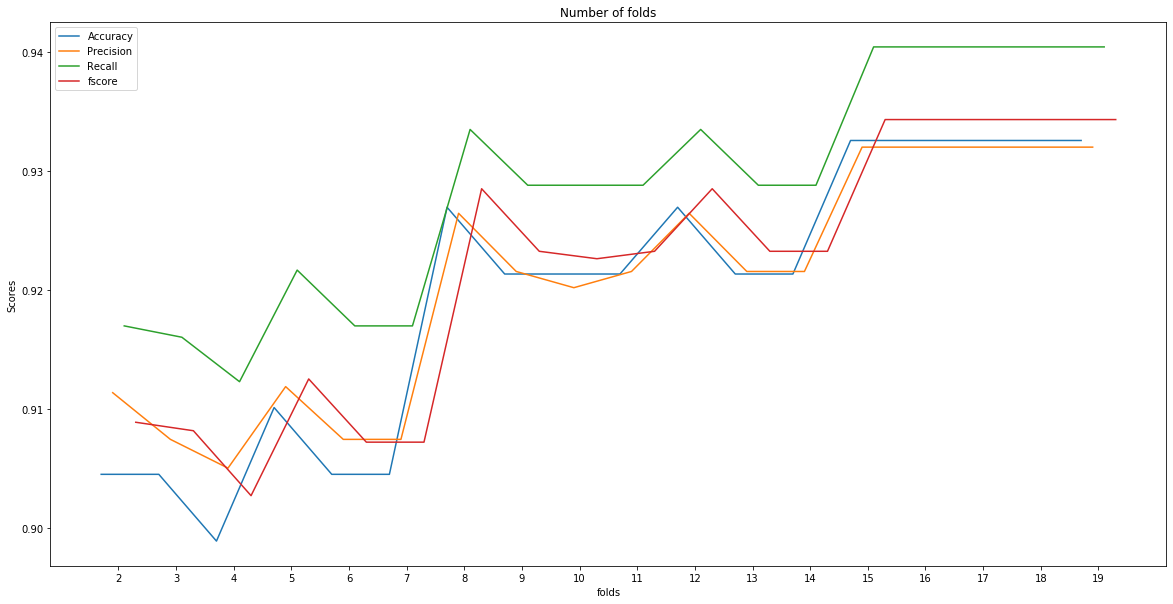

,accuracy,precision,recall,fscore,cm
folds,,,,,
2,0.904494,0.911363,0.916983,0.908875,"[[58, 0, 1], [0, 47, 1], [12, 3, 56]]"
3,0.904494,0.907438,0.916028,0.908162,"[[57, 0, 2], [0, 47, 1], [10, 4, 57]]"
4,0.898876,0.905017,0.912288,0.902698,"[[58, 0, 1], [0, 47, 1], [12, 4, 55]]"
5,0.910112,0.911873,0.921678,0.912519,"[[58, 0, 1], [0, 47, 1], [9, 5, 57]]"
6,0.904494,0.907435,0.916983,0.907201,"[[58, 0, 1], [0, 47, 1], [10, 5, 56]]"
7,0.904494,0.907435,0.916983,0.907201,"[[58, 0, 1], [0, 47, 1], [10, 5, 56]]"
8,0.926966,0.926458,0.933513,0.928523,"[[58, 0, 1], [0, 46, 2], [6, 4, 61]]"
9,0.921348,0.921563,0.928818,0.923261,"[[58, 0, 1], [0, 46, 2], [7, 4, 60]]"
10,0.921348,0.920197,0.928818,0.922635,"[[58, 0, 1], [0, 46, 2], [6, 5, 60]]"


In [64]:
ax, df = test_folds(X, y, KNeighborsClassifier, range(2,20,1), kfold=StratifiedKFold)
plt.show()
df

In [67]:
def test_cross_val(X, y, classifier, kfolds,
               normalizer=None):
    X = X.copy()
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    data = {'cross_val': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, kfold in enumerate(kfolds):
        name = f'{kfold.__class__.__name__}-{kfold.n_splits}_{index}'
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X, y,
                                     talk=False)
        data['cross_val'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('cross_val')
    return plot_results(df, 'Cross-validation method'), df

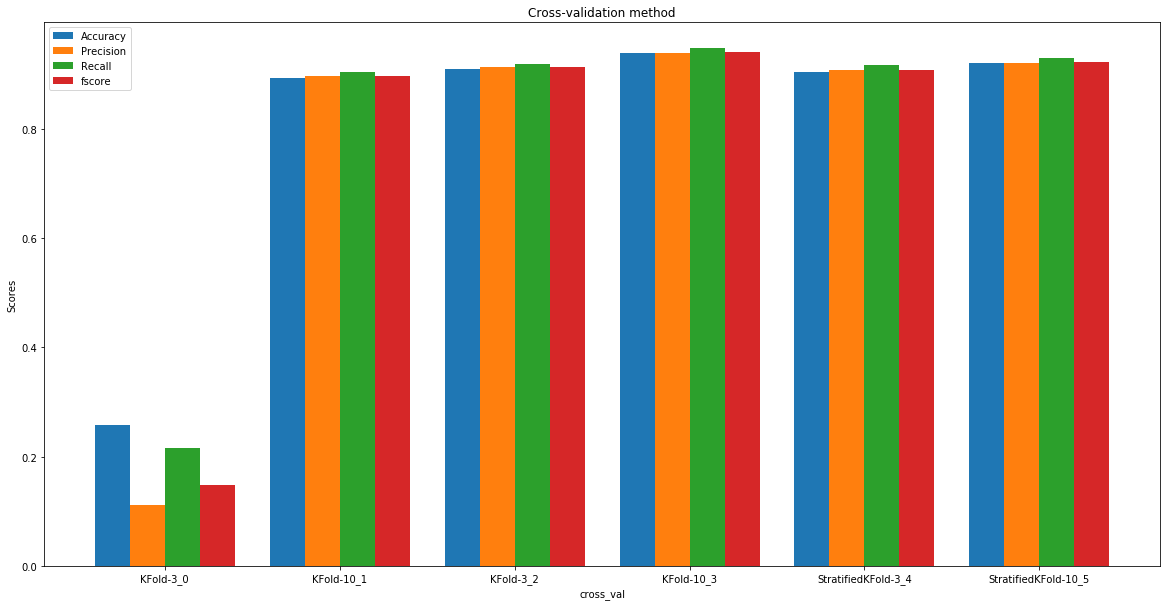

,accuracy,precision,recall,fscore,cm
cross_val,,,,,
KFold-3_0,0.258427,0.111922,0.215962,0.147436,"[[0, 1, 58], [15, 0, 33], [18, 7, 46]]"
KFold-10_1,0.893258,0.897190,0.904389,0.897125,"[[57, 0, 2], [0, 46, 2], [11, 4, 56]]"
KFold-3_2,0.910112,0.912973,0.918474,0.913684,"[[57, 0, 2], [0, 46, 2], [9, 3, 59]]"
KFold-10_3,0.938202,0.939118,0.947402,0.940825,"[[58, 0, 1], [0, 48, 0], [7, 3, 61]]"
StratifiedKFold-3_4,0.904494,0.907438,0.916028,0.908162,"[[57, 0, 2], [0, 47, 1], [10, 4, 57]]"
StratifiedKFold-10_5,0.921348,0.920197,0.928818,0.922635,"[[58, 0, 1], [0, 46, 2], [6, 5, 60]]"


In [68]:
ax, df = test_cross_val(X, y, KNeighborsClassifier(), [KFold(3, False), KFold(10, False), KFold(3, True), KFold(10, True), StratifiedKFold(3), StratifiedKFold(10)])
plt.show()
df

In [70]:
def test_normalization(X, y, classifier, normalizers,
                       kfold=None):
    X = X.copy()
    if kfold is None:
        kfold = StratifiedKFold(10)
    data = {'normalizer': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, normalizer in enumerate(normalizers):
        name = f'{normalizer.__class__.__name__}_{index}'
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X_new = X.copy()
        X_new[:] = X_preprocessed
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate(classifier,
                                     kfold,
                                     X_new, y,
                                     talk=False)
        data['normalizer'].append(name)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index('normalizer')
    return plot_results(df, 'Normalization method'), df

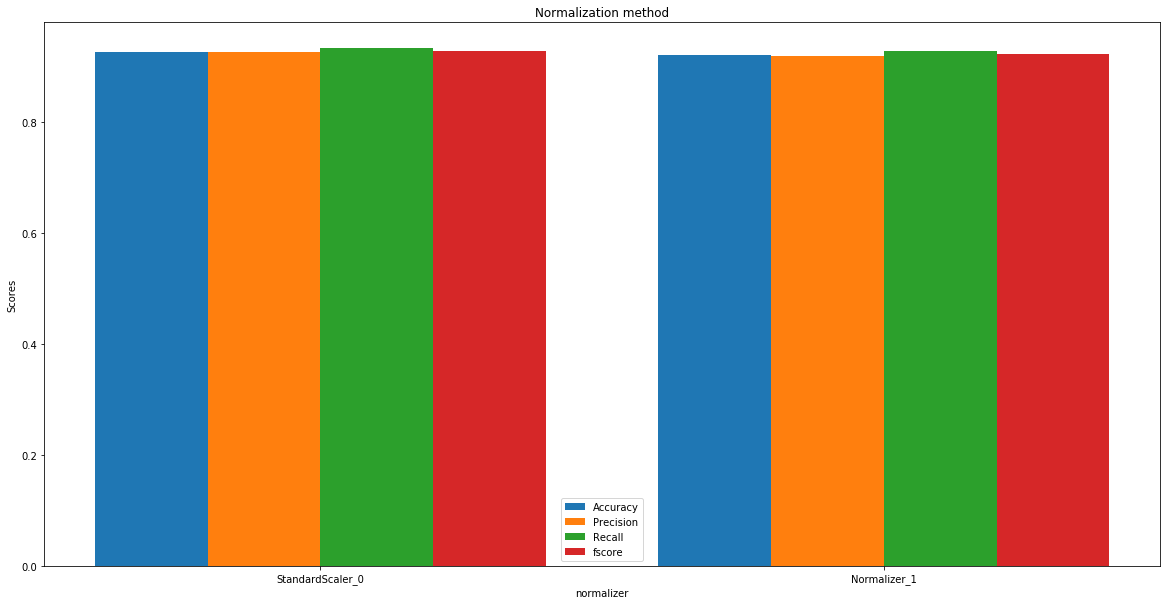

,accuracy,precision,recall,fscore,cm
normalizer,,,,,
StandardScaler_0,0.926966,0.926458,0.933513,0.928523,"[[58, 0, 1], [0, 46, 2], [6, 4, 61]]"
Normalizer_1,0.921348,0.920197,0.928818,0.922635,"[[58, 0, 1], [0, 46, 2], [6, 5, 60]]"


In [71]:
ax, df = test_normalization(X, y, KNeighborsClassifier(), [standardizer, normalizer])
plt.show()
df